In [ ]:
# default_exp learner

# Learner

> This contains fastai2 Learner extensions.

In [ ]:
#export
from fastai2.learner import * 
from tsai.imports import *

In [ ]:
#export
@patch
def save_all(self:Learner, path='export', dls_fname='dls', model_fname='model', learner_fname='learner'):
    
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)

    # Save the dls
    torch.save(self.dls, path/f'{dls_fname}.pth')

    # Saves the model along with optimizer
    self.model_dir = path
    self.save(model_fname)

    # Export learn without the items and the optimizer state for inference
    self.export(path/f'{learner_fname}.pkl')
    
    print(f'Learner saved:')
    print(f"path          = '{path}'")
    print(f"dls_fname     = '{dls_fname}'")
    print(f"model_fname   = '{model_fname}.pth'")
    print(f"learner_fname = '{learner_fname}.pkl'")
    
# Learner.save_all = save_all
    
    
def load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner', cpu=True):
    path = Path(path)
    learn = load_learner(path/f'{learner_fname}.pkl', cpu=cpu)
    learn.load(f'{model_fname}')
    dls = torch.load(path/f'{dls_fname}.pth')
    learn.dls = dls
    return learn

In [ ]:
#export
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
from tsai.data.all import *
from tsai.models.all import *
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(1, lr_max=1e-3)

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : ((#30) [0,1,2,3,4,5,6,7,8,9...], (#30) [30,31,32,33,34,35,36,37,38,39...])


epoch,train_loss,valid_loss,accuracy,time
0,1.467547,1.415891,0.133333,00:10


In [ ]:
learn.save_all()
del learn
learn = load_learner_all()

Learner saved:
path          = 'export'
dls_fname     = 'dls'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


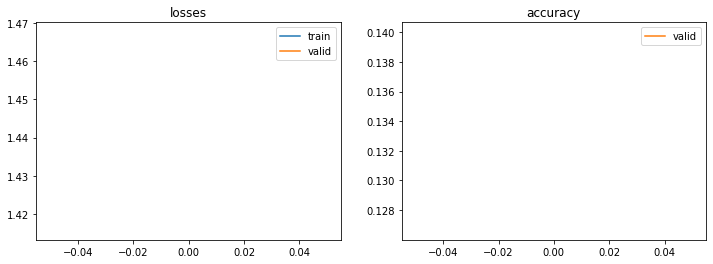

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
#hide
create_scripts()
beep()